# **Using Univariate time series model to predict the stock prices of Alaska Airlines.**

# Import Data

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Uploading AlaskaAirlines.csv file

In [ ]:
dataset_train = pd.read_csv('AlaskaAirlines.csv')
training_set = dataset_train.iloc[:, 4:5].values # use only closing price as input data
dataset_train.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-01-02,19.797240,19.882671,19.603898,19.756773,2173400,0.0,0.0
1,2013-01-03,19.797239,20.152448,19.478002,20.125469,2602600,0.0,0.0
2,2013-01-04,20.120976,20.458199,20.093997,20.404243,1215000,0.0,0.0


# Transform Data

Data Normalization using MinMax Scaler.

In [ ]:
# As we now, we need to scale our dataet
# Feature Scaling using MinMax scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
len(training_set)

2245

Traning data is the daily observations of Alaska Airlines Stock price January 2013 till January 2021. We have 2245 observations in this dataset.


# Training Data

Here we specify the time window, We are using the time window of 30. We look at the past 30 days values to predict future values. We can also increase or decrease the time window with respect to the data availability

In [ ]:
window=30

In [ ]:
X_train = []
y_train = []
for i in range(window, len(training_set)):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping the data to fit the required format.

In [ ]:
# Reshaping the data so that it fits the format required for the RNN input layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# 3D data structure (tensor) allowing for more than 1 variable, (number of observations,number of time steps,1)
X_train.shape

(2215, 30, 1)

Structure:
* 2215- Number of observations(Actual number- time frame)
* 30 - Time window specified
* 1  - Number of variables/features.

# Test Data

Here our testing/validation dataset has stock prices from 1st Jan 2022 to 31st Mar 2022.
 
we have 62 observations in the test set.

In [ ]:
dataset_test = pd.read_csv('AlaskaAirlines_test-2.csv')
dataset_test.head(2), dataset_test.tail(2), len(dataset_test)

(         Date       Open       High        Low      Close   Volume  Dividends  \
 0  2022-01-03  52.860001  54.630001  52.830002  54.070000  1942000          0   
 1  2022-01-04  55.189999  55.610001  54.330002  55.450001  2613800          0   
 
    Stock Splits  
 0             0  
 1             0  ,
           Date       Open       High        Low      Close   Volume  \
 60  2022-03-30  57.849998  58.599998  57.389999  58.009998  1635400   
 61  2022-03-31  58.169998  58.849998  57.630001  58.009998  1438000   
 
     Dividends  Stock Splits  
 60          0             0  
 61          0             0  ,
 62)

In [ ]:
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values  
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) 

X_test = []
y_test = []
for i in range(window, len(inputs)): 
    X_test.append(inputs[i-window:i, 0])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#let's make sure our datasets are shaped correctly before we proceed...
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(2215, 30, 1) (2215,) (62, 30, 1) (62,)


# RNN Model

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
print(tf.__version__)

2.8.0




1. Build an LSTM model with two layers.
2. Each layer with 50 units
3. Used dropout layer of 0.2 to prevent overfitting of data
4. Adding the output layer.



In [ ]:
# Initialisi#ng the RNN
ts= keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
ts.add(layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
ts.add(layers.Dropout(0.2))  #randomly drops 20% of observations to avoid overfitting

# Adding a second LSTM layer and some Dropout regularisation
# Note that the "return_sequences=False (default value)" for the last RNN layer and True for previous layers
ts.add(layers.LSTM(units = 50)) 
ts.add(layers.Dropout(0.2))

# Adding the output layer
ts.add(layers.Dense(units = 1))


In [ ]:
ts.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# we use "Mean Squared Error" as our loss function 
ts.compile(optimizer = 'adam', #can also try  optimizer='rmsprop'
           loss = 'mean_squared_error', # mean_absolute_error
           metrics=['MeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError']) #MSE, MAE, MAPE

Traning the LSTM model for 30 epochs.

In [ ]:
# Fitting the RNN to the Training set
history_LSTM=ts.fit(X_train, y_train, 
               epochs = 30, batch_size = 30,verbose=1,
               validation_data=(X_test,y_test))


Epoch 1/30
74/74 [==============================] - 7s 44ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1015 - mean_absolute_percentage_error: 28.1026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0396 - val_mean_absolute_percentage_error: 8.8569
Epoch 2/30
74/74 [==============================] - 2s 30ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 12.5723 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0382 - val_mean_absolute_percentage_error: 8.9849
Epoch 3/30
74/74 [==============================] - 2s 30ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 12.2361 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0387 - val_mean_absolute_percentage_error: 8.7401
Epoch 4/30
74/74 [==============================] - 2s 30ms/step

# Evaluate RNN Model

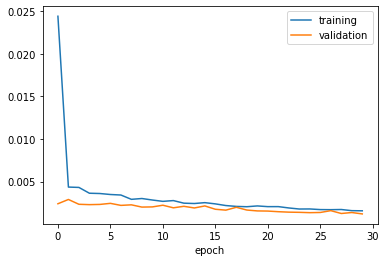

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_LSTM.history['loss'],label="training")
plt.plot(history_LSTM.history['val_loss'],label="validation")
plt.xlabel("epoch")
plt.legend()
plt.show()

From the plot ,it has been observed that training loss decreases until 20 epochs and becomes almost stable after that.So 20 epochs can be considered as the optimal one from the above but there is a constant
validation loss observed after few epochs 

In [ ]:
real_stock_price = dataset_test.iloc[:, 4:5].values #outcome var=Close price
len(real_stock_price)
#this is the number of future time units we will make predictions for

62

In [ ]:
predicted_stock_price = ts.predict(X_test)
# note that we need to inverse_transform the predicted values 
# because the predictions are on the scaled [0,1] range (we MinMax scaled our data before training)
predicted_stock_price_LSTM = sc.inverse_transform(predicted_stock_price)

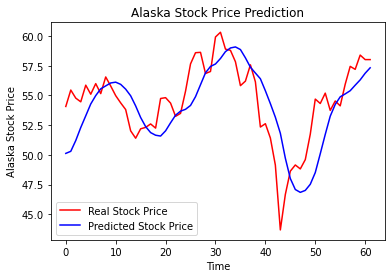

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price_LSTM, color = 'blue', label = 'Predicted Stock Price')
plt.title('Alaska Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Alaska Stock Price')
plt.legend()
plt.show()


Evaluating RMSE and MAE values.
* Resulting RMSE and MAE values are printed below.




In [ ]:
from sklearn import metrics
import math
#print('Coefficients: \n', lin_reg.coef_) #regression coefficients
print("Root Mean squared error: %.2f" % math.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price_LSTM))) #RMSE
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(real_stock_price, predicted_stock_price_LSTM)) #MAE

Root Mean squared error: 2.58
Mean absolute error: 2.01


We can further improve the model's performance by using hyper parameter tuning with respect to layers,units,drop out and test it on other datasets for better generalization.